In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import random

# 自定义 MAPE 损失函数
class MAPE_Loss(nn.Module):
    def __init__(self):
        super(MAPE_Loss, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  # 避免除零
        return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [2]:
# 读取数据
data = pd.read_csv("../data/dataset.csv")

# 数据分割
data['target_class'] = pd.qcut(data['Cs'], q=10, labels=False)
X = data.drop(['Cs', 'target_class'], axis=1).values
y = data['Cs'].values
stratify_column = data['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)

# 数据标准化
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建 DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
X_train_tensor

tensor([[ 0.0291, -0.7687, -0.6003,  ...,  0.2674, -0.5044, -0.1394],
        [ 0.9981, -0.0516,  1.5878,  ..., -0.3791, -0.5044, -0.4421],
        [-0.2552,  0.2528, -0.6484,  ..., -0.2174, -0.5044,  0.3795],
        ...,
        [-0.5987,  3.5067, -0.5270,  ..., -0.3791, -0.5044, -0.4637],
        [ 0.6404,  1.8628, -1.3675,  ...,  0.2674, -0.5044, -0.3988],
        [ 0.4200, -0.2580,  1.3366,  ..., -0.3791, -0.5044, -0.4637]])

In [3]:
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 12)
        self.layer2 = nn.Linear(12, 90)
        self.layer3 = nn.Linear(90, 90)
        self.layer4 = nn.Linear(90, 60)
        self.layer5 = nn.Linear(60, 70)
        self.layer6 = nn.Linear(70, 30)
        self.output = nn.Linear(30, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x = torch.relu(self.layer6(x))
        x = self.output(x)
        return x

# 初始化模型
input_dim = X_train_scaled.shape[1]
model = ANN(input_dim)

# 选择损失函数 (可以选择 MAPE 或 RMSE)
loss_function = MAPE_Loss()
# loss_function = RMSE_Loss()  # 或者使用 MAPE_Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# 重新定义模型结构
model = ANN(input_dim)  # 使用相同的模型结构

# 加载模型参数，确保使用 weights_only=True 来提高安全性
model.load_state_dict(torch.load("ann_model.pth", weights_only=True))  # 加载模型参数

# 评估模型 (确保在 GPU 上)
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).cpu().numpy()  # 转换为 CPU 数据，便于后续处理
    y_test_pred = model(X_test_tensor).cpu().numpy()

y_train_pred = y_train_pred.squeeze()
y_test_pred = y_test_pred.squeeze()

ValueError: Feature 'N' not in feature_names

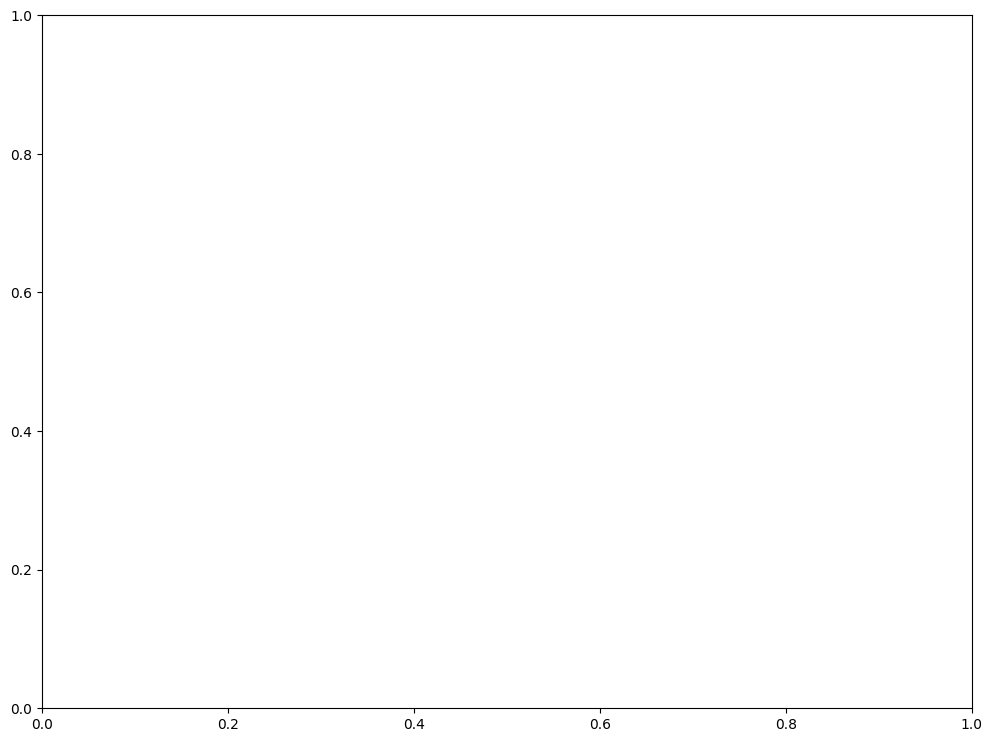

In [10]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

# 指定要计算2D部分依赖图的特征（使用元组而不是列表）
features = ('N', 'O')

fig, ax = plt.subplots(figsize=(12, 9))
pdp_display = PartialDependenceDisplay.from_estimator(model, X_train_scaled, [features], ax=ax, grid_resolution=100)
pdp_display.pd_results